In [8]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import datetime as dt

In [21]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

In [4]:
def xirr(transactions):
    years = [(ta[0] - transactions[0][0]).days / 365.0 for ta in transactions]
    residual = 1
    step = 0.05
    guess = 0.08
    epsilon = 0.0001
    limit = 10000
    while abs(residual) > epsilon and limit > 0:
        limit -= 1
        residual = 0.0
        for i, ta in enumerate(transactions):
            residual += ta[1] / pow(guess, years[i])
        if abs(residual) > epsilon:
            if residual > 0:
                guess += step
            else:
                guess -= step
                step /= 2.0
    return guess-1

In [5]:
x=pd.read_csv('IRR_data.csv',index_col=3,parse_dates=['Transaction Date'])
sp=pd.read_csv('SP500.csv',parse_dates=['DATE'],index_col=0,na_values='.')

In [6]:
df=pd.read_csv('IRR_data.csv',parse_dates=['Transaction Date'],na_values='.')
df=pd.pivot_table(df,columns='Security Description',index='Transaction Date')
df['SP']=sp.SP500


# Calculate IRR 

In [9]:
funds={}
funds_wo_fee={}
sp_rtn=pd.Series()
year=pd.Series()
for r in x.iterrows():
    if r[0] not in funds.keys():
        funds[r[0]]=[]
        funds_wo_fee[r[0]]=[]
        year[r[0]]=r[1]['Transaction Date'].date().year
        ann_years=(dt.datetime.today().date()-r[1]['Transaction Date'].date()).days/365.
        sp_rtn[r[0]]=(sp.ix[-1].SP500/df.SP.ffill()[r[1]['Transaction Date']])**(1/ann_years)-1
    try:
        funds[r[0]].append([r[1]['Transaction Date'].date(),float(r[1]['Reporting Amount'])])
        if r[1]['Type']!='Fees paid - Asset account':
            funds_wo_fee[r[0]].append([r[1]['Transaction Date'].date(),float(r[1]['Reporting Amount'])])
    except:
        continue
    

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


In [10]:
rtn=pd.Series()
rtn_wo=pd.Series()
results=pd.DataFrame()
for f in funds.keys():
    val=round(xirr(funds[f])*100.,2)
    val_wo=round(xirr(funds_wo_fee[f])*100.,2) 
    if val>100:
        continue
    rtn[f]=val
    rtn_wo[f]=val_wo
results['IRR']=rtn
results['IRR without fees']=rtn_wo
results['Vintage']=year
results['SP Annualized Return since Inception']=(sp_rtn*100.).round(2)
results=results.sort_values('IRR')

In [11]:
results

,IRR,IRR without fees,Vintage,SP Annualized Return since Inception
Coachman Energy VII Offshore Feeder Bn,-34.53,-34.07,2015,9.43
HH Pre-IPO Offshr Feeder Fd II LP S B Bn,-10.12,-2.82,2017,14.07
Eur Special Sits Offshr Feeder Fd LP Bn,-3.15,-0.89,2016,17.35
European Primary Lending Opp Offshore Bn,1.91,2.54,2014,9.22
"W ST DF Onshore Feeder Fund, L.P. B",2.68,5.50,2016,15.01
C VIII Real Estate Opp Onshore A,3.06,4.83,2017,14.76
G Rockies Offshore Feeder Fund Ltd Bn,3.94,4.90,2015,12.42
"BTO II Offshore Feeder Fund, Ltd. Bn",4.72,7.38,2015,14.12
"CTP Offshore Feeder Fund, L.P. Bn",5.63,6.56,2014,9.75
Wellington HH Pr-IPO Ofshr Feeder Fd Bn,6.45,7.54,2015,9.47


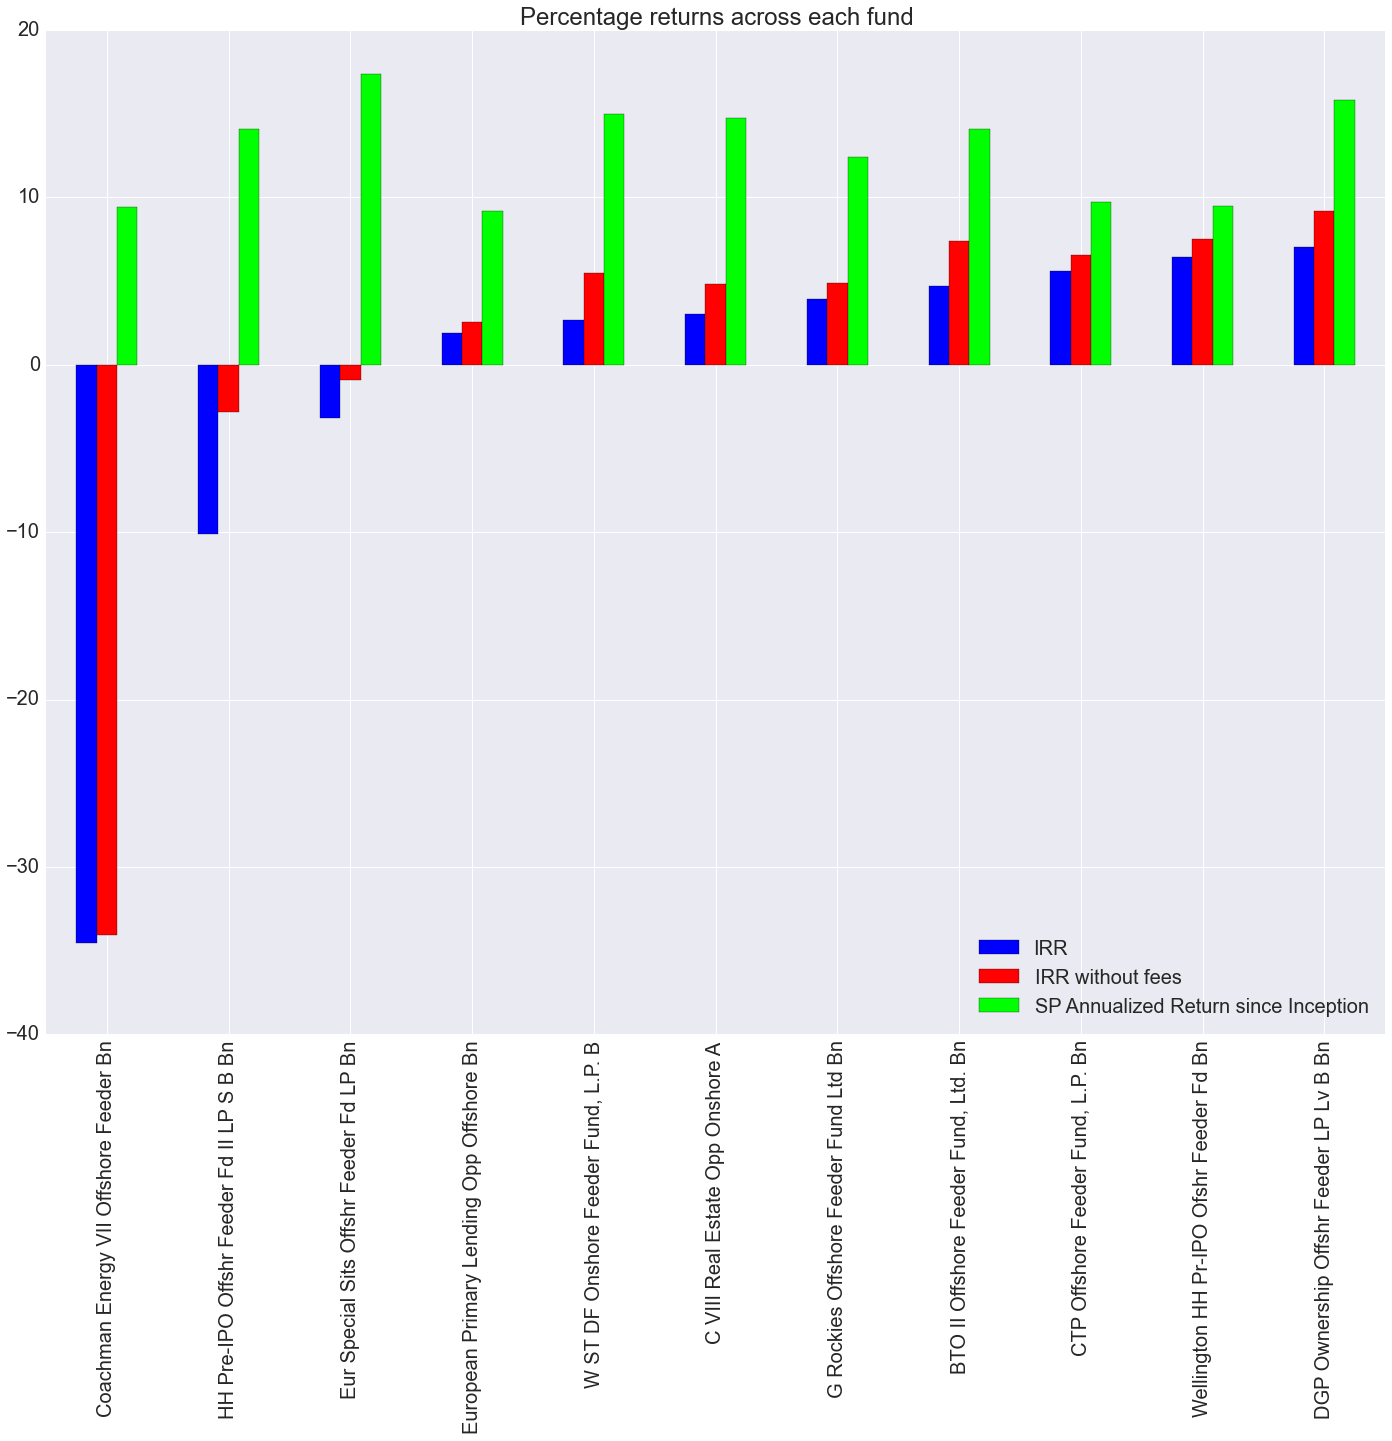

In [22]:
results[['IRR','IRR without fees','SP Annualized Return since Inception']].plot(kind='bar',colormap='brg', title='Percentage returns across each fund')

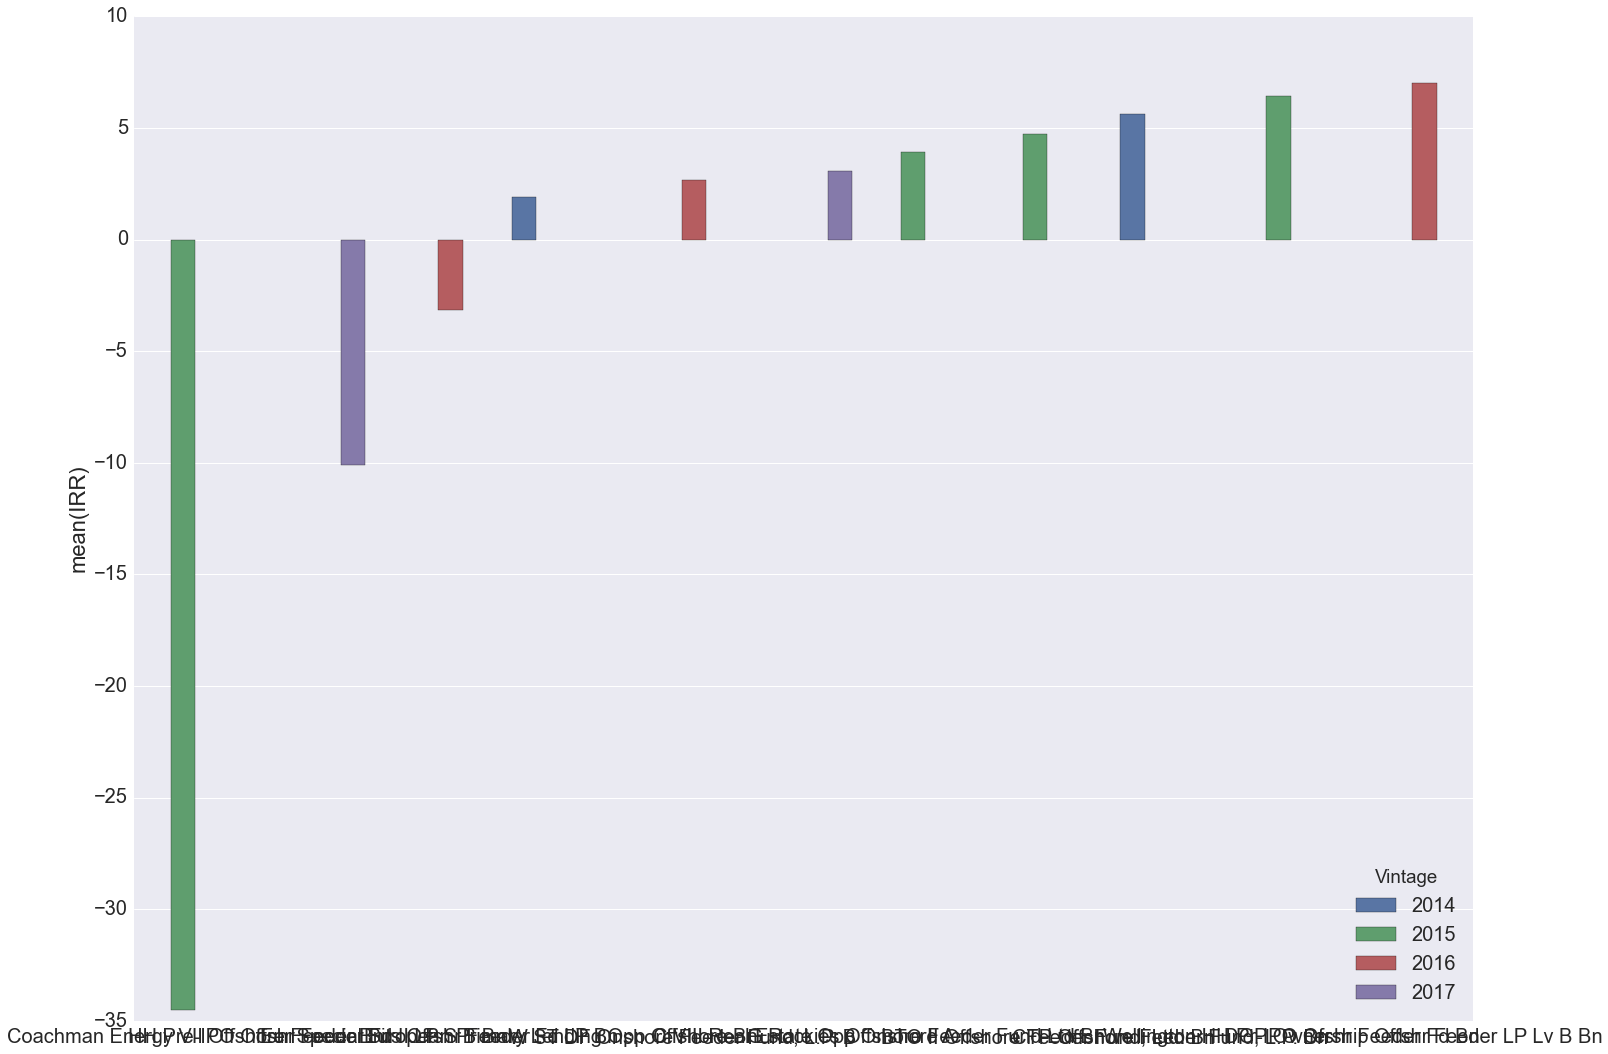

In [23]:
sns.barplot(results.index,results.IRR,hue=results.Vintage,orient=0)

# Time series of Capital

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


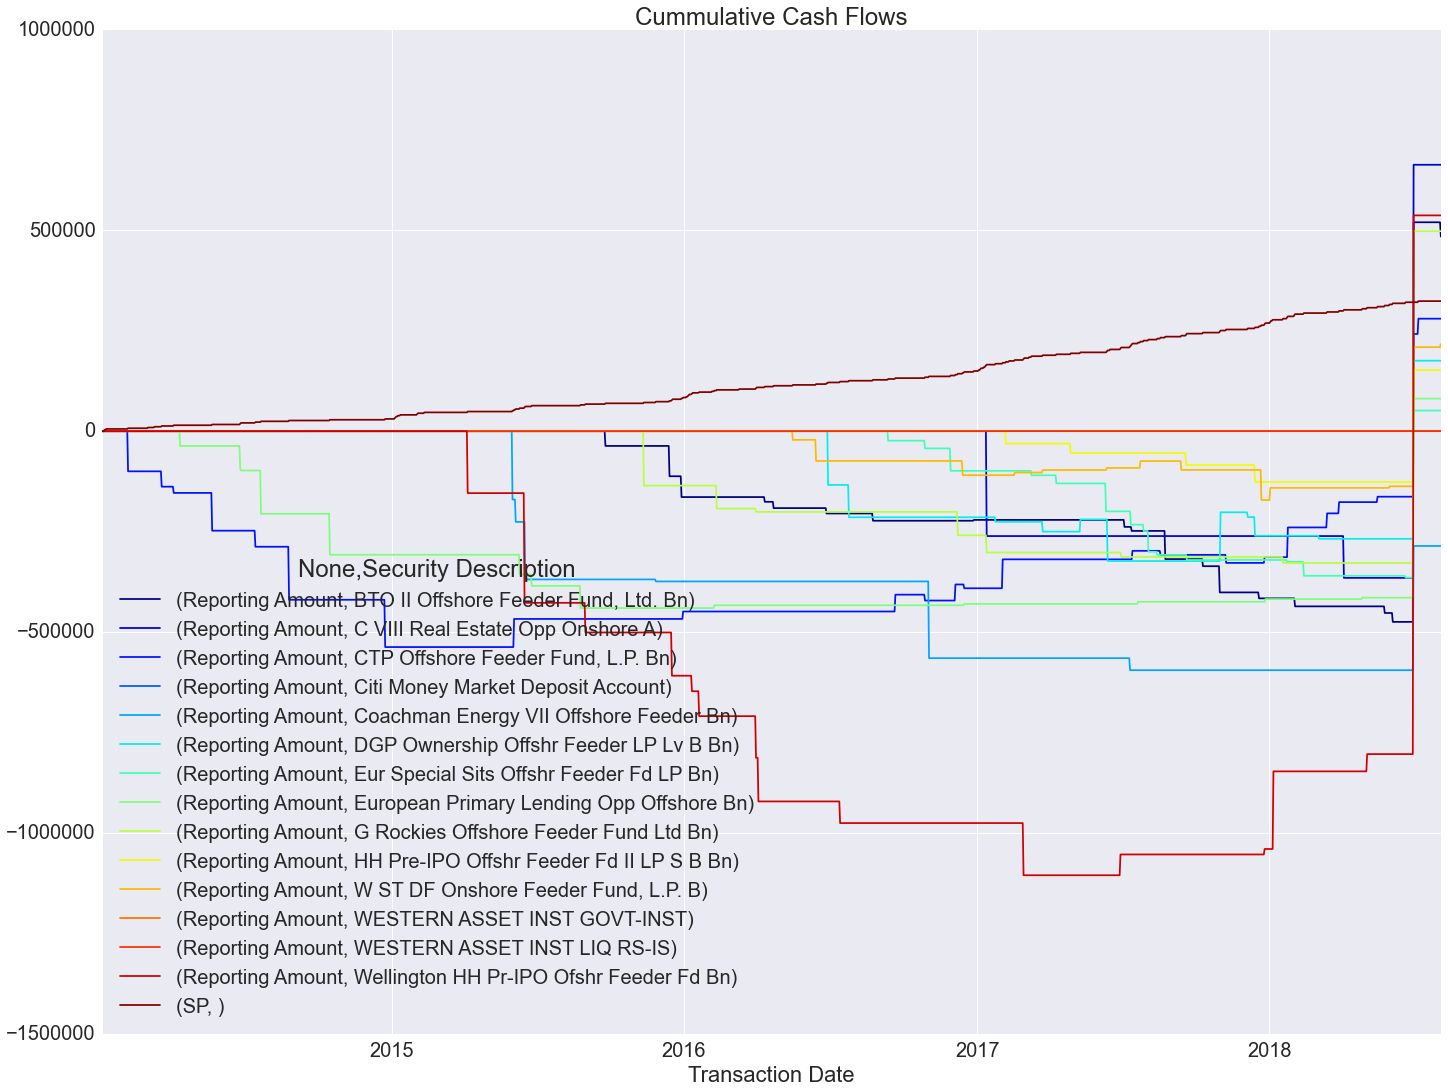

In [24]:
df.resample(rule='d',how='sum').cumsum().plot(colormap='jet',title='Cummulative Cash Flows')

# Return Multiples 

In [25]:
flows={}
for f in funds.keys():
    inflow=0
    outflow=0
    for r in funds[f]:
        if r[1]>0:
            inflow=inflow+r[1]
        else:
            outflow=outflow+r[1]
    flows[f]=[inflow,outflow*-1.]

In [26]:
a=pd.DataFrame(flows,index=['Inflow','Outflow']).T

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


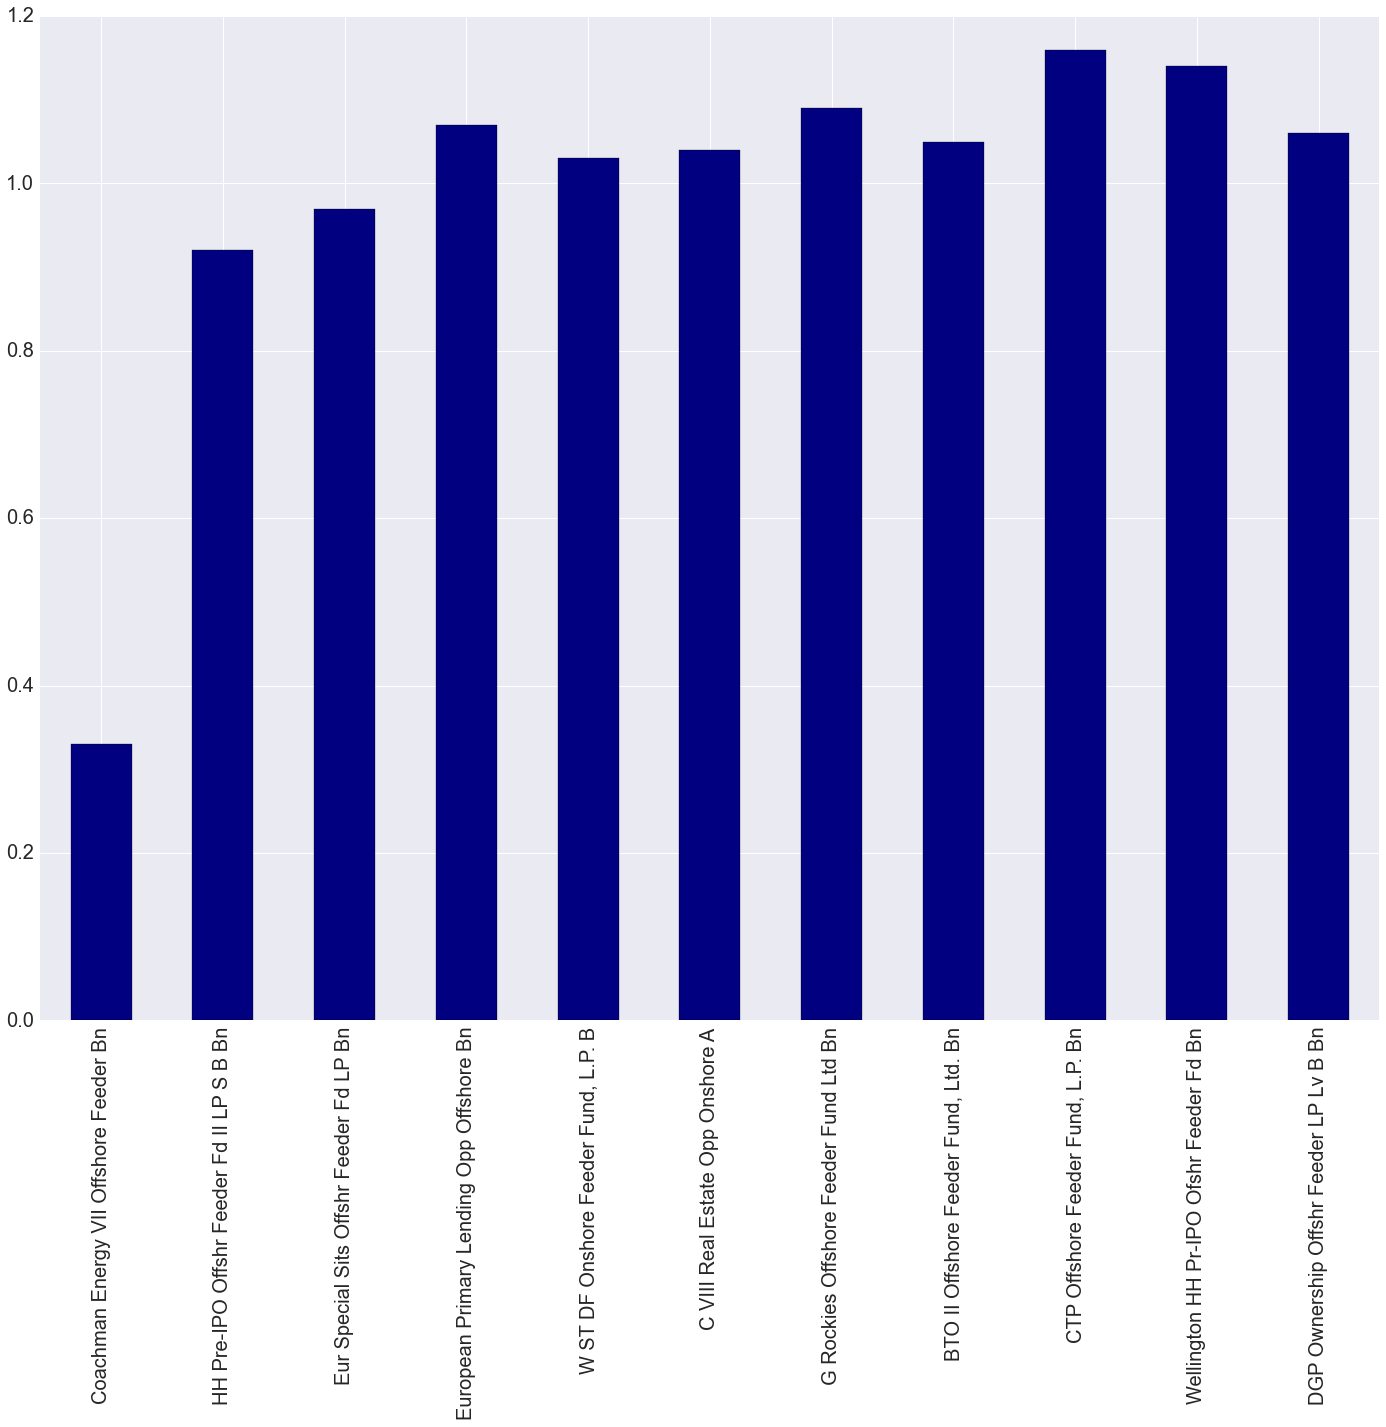

In [27]:
(a.Inflow/a.Outflow).round(2).ix[results.index].plot(kind='bar',colormap='jet')

In [28]:
final_res=results[[u'IRR', u'IRR without fees',
       u'SP Annualized Return since Inception']]
final_res['Multiples']=(a.Inflow/a.Outflow).round(2).ix[results.index]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10da99890>], dtype=object)

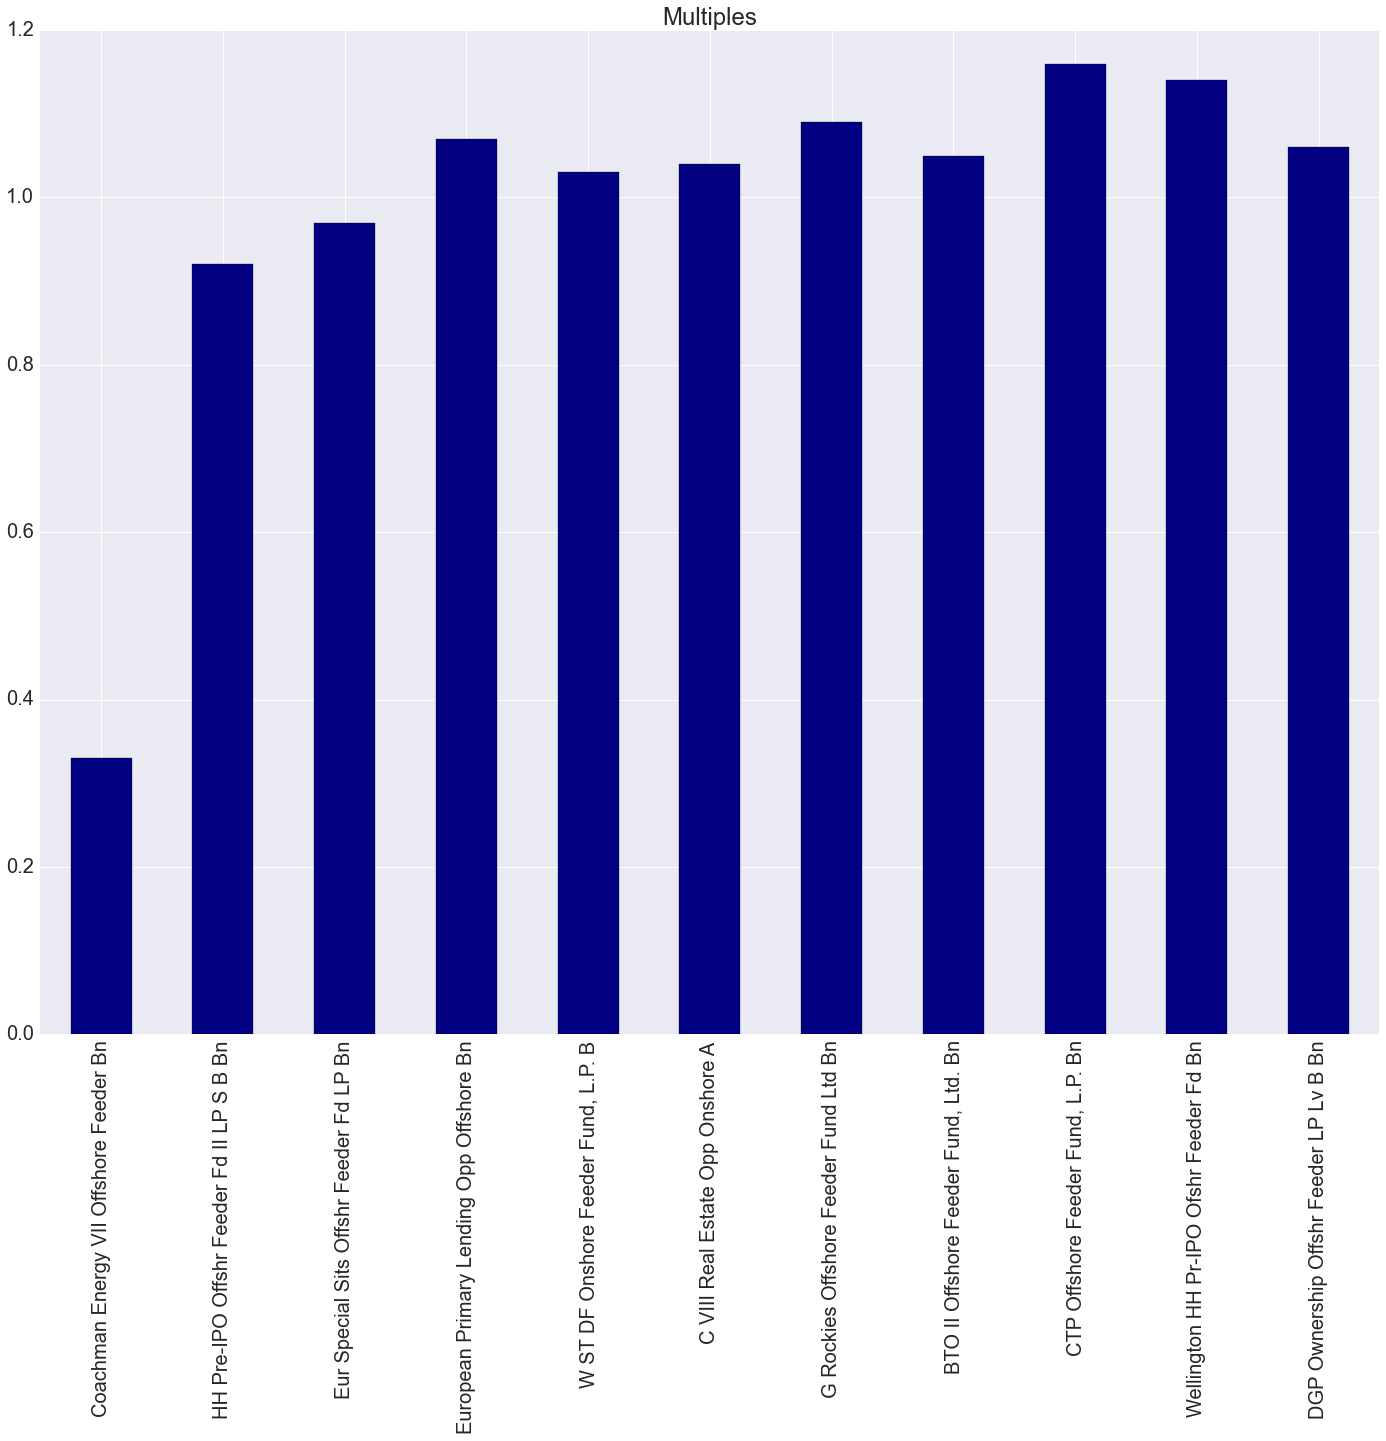

In [29]:
final_res.Multiples.plot(kind='bar',subplots=True,colormap='jet')

# March 2018 Valuation

In [30]:
data=pd.read_csv('IRR_data_March18.csv',index_col=3,parse_dates=['Transaction Date'])

In [33]:
sp.resample(rule='q',how='last').ix[-3]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


SP500    2640.87
Name: 2018-03-31 00:00:00, dtype: float64

In [56]:
funds={}
funds_wo_fee={}
sp_rtn=pd.Series()
year=pd.Series()
for r in x.iterrows():
    if r[0] not in funds.keys():
        funds[r[0]]=[]
        funds_wo_fee[r[0]]=[]
        year[r[0]]=r[1]['Transaction Date'].date()
        ann_years=(dt.datetime.today().date()-r[1]['Transaction Date'].date()).days/365.
        sp_rtn[r[0]]=(sp.resample(rule='q',how='last').ix[-3].SP500/df.SP.ffill()[r[1]['Transaction Date']])**(1/ann_years)-1
    try:
        funds[r[0]].append([r[1]['Transaction Date'].date(),float(r[1]['Reporting Amount'])])
        if r[1]['Type']!='Fees paid - Asset account':
            funds_wo_fee[r[0]].append([r[1]['Transaction Date'].date(),float(r[1]['Reporting Amount'])])
    except:
        continue
    

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  # This is added back by InteractiveShellApp.init_path()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


In [61]:
rtn=pd.Series()
rtn_wo=pd.Series()
results_march=pd.DataFrame()
for f in funds.keys():
    val=round(xirr(funds[f])*100.,2)
    val_wo=round(xirr(funds_wo_fee[f])*100.,2) 
    if val>100:
        continue
    rtn[f]=val
    rtn_wo[f]=val_wo
results_march['IRR']=rtn/100.
results_march['IRR without fees']=rtn_wo/100.
results_march['Vintage']=year
results_march['SP Annualized Return since Inception']=(sp_rtn).round(4)
results_march=results_march.sort_values('IRR')

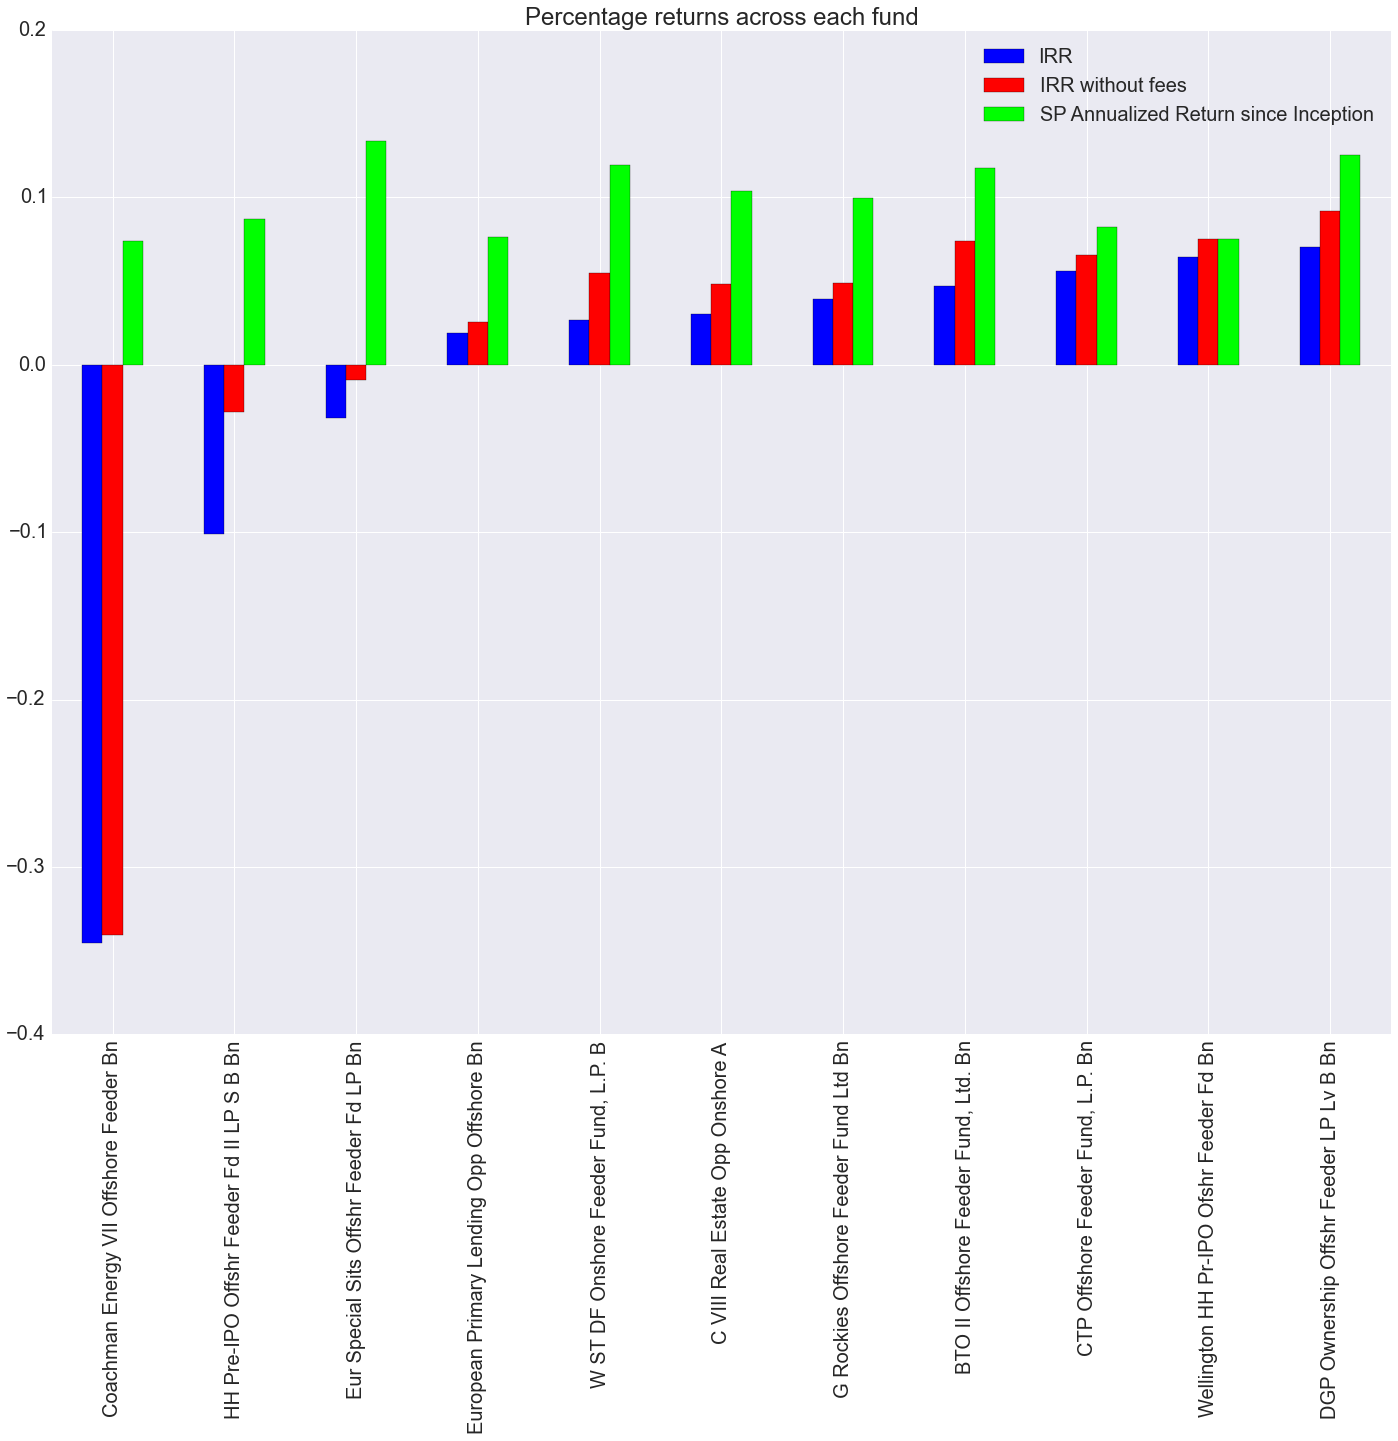

In [64]:
results_march[['IRR','IRR without fees','SP Annualized Return since Inception']].plot(kind='bar',colormap='brg', title='Percentage returns across each fund')

In [65]:
results_march.sort_values('Vintage')

,IRR,IRR without fees,Vintage,SP Annualized Return since Inception
"CTP Offshore Feeder Fund, L.P. Bn",0.0563,0.0656,2014-03-20,0.0826
European Primary Lending Opp Offshore Bn,0.0191,0.0254,2014-06-26,0.0765
Wellington HH Pr-IPO Ofshr Feeder Fd Bn,0.0645,0.0754,2015-04-06,0.0752
Coachman Energy VII Offshore Feeder Bn,-0.3453,-0.3407,2015-06-01,0.0739
"BTO II Offshore Feeder Fund, Ltd. Bn",0.0472,0.0738,2015-09-25,0.1175
G Rockies Offshore Feeder Fund Ltd Bn,0.0394,0.0490,2015-11-12,0.0997
"W ST DF Onshore Feeder Fund, L.P. B",0.0268,0.0550,2016-05-16,0.1193
DGP Ownership Offshr Feeder LP Lv B Bn,0.0703,0.0921,2016-06-29,0.1256
Eur Special Sits Offshr Feeder Fd LP Bn,-0.0315,-0.0089,2016-10-28,0.1340
C VIII Real Estate Opp Onshore A,0.0306,0.0483,2017-01-13,0.1037
